In [2]:
from scapy.all import *
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import networkx as nx

In [16]:
# OLD
def createDataFrame(pkt_lst):
    protos = []
    dst_type = []
    
    for pkt in pkt_lst:
        try:  
            ptype = {
                0x0800: 'IPv4',
                0x0806: 'ARP',
                0x8137: 'IPX',
                0x86dd: 'IPv6',
                0x88cc: 'LLDP'
            }.get(pkt.type, pkt.type)
        except AttributeError:
            ptype = 'Other'
            pass
        if ptype != 'Other':
            protos.append(ptype)
            isBcast = pkt.dst == 'ff:ff:ff:ff:ff:ff'
            if isBcast:
                dst_type.append("broadcast")
            else:
                dst_type.append("unicast")
    
    data_dict = {'protocolos': protos, 'destinos': dst_type}
    
    return pd.DataFrame.from_dict(data_dict)

def probability_chart(df):
    total =  df.shape[0]
    return (df.groupby(['simbolo']).size() / total).reset_index(name='probabilidad')

def entropy_old(df):
    probs = probability_chart(df)
    sum = 0
    for index, row in probs.iterrows():
        prob = row['probabilidad']
        sum += prob * (- math.log2(prob))
        print(prob, (- math.log2(prob)))
    return sum

def max_entropy_old(df):
    return math.log2(df.groupby(['protocolos', 'destinos']).size().reset_index().count()[0])

def plotProtocols(dframe, size=(8,8)):
    dframe.protocolos.value_counts(sort=False).plot.pie(figsize=size)

def getNoTypePkts(pkt_lst):
    pkts = []

    for pkt in pkt_lst:
        try:  
            ptype = pkt.type
        except AttributeError:
            pkts.append(pkt)
            pass
        
    return pkts
# NEW
def createDataFrame_s1(pkt_lst):
    protos = []
    dsts = []
    for pkt in pkt_lst:
        try:  
            ptype = {
                0x0800: 'IPv4',
                0x0806: 'ARP',
                0x8137: 'IPX',
                0x86dd: 'IPv6',
                0x88cc: 'LLDP'
            }.get(pkt.type, pkt.type)
        except AttributeError:
            ptype = 'Other'
            pass
        if ptype != 'Other':
            protos.append(ptype)
            isBcast = pkt.dst == 'ff:ff:ff:ff:ff:ff'
            if isBcast:
                dsts.append("broadcast")
            else:
                dsts.append("unicast")
    
    data_dict = {'protocolo': protos, 'dst': dsts}
    
    df = pd.DataFrame.from_dict(data_dict)
    df['simbolo'] = df['protocolo'] + ' ' + df['dst']
    
    return df
    
def createDataFrame_s2(pkt_lst):
    arp_type = []
    srcs = []
    dsts = []
    for pkt in pkt_lst:
        if scapy.layers.l2.ARP in pkt and pkt.psrc != pkt.pdst:
            if scapy.layers.l2.ARP.is_at == pkt.op:
                arp_type.append('is-at')
            else:
                arp_type.append('who-has')
            srcs.append(pkt.psrc)
            dsts.append(pkt.pdst)

    data_dict = {'tipo': arp_type, 'src': srcs, 'dst': dsts}

    df = pd.DataFrame.from_dict(data_dict)
    df['simbolo'] = df['tipo'] + ' ' + df['dst'] 
    
    return df
    



In [66]:
def summaryDataFrame(df):
    total =  df.shape[0]
    size = df.groupby(['simbolo']).size()
    prob = size / total
    info = prob.apply(math.log2) * -1
    
    return pd.DataFrame({'simbolo':size.index, 'total':size.values, 'prob': prob.values, 'info': info.values})

def entropy(df):
    return sum(df["prob"] * df["info"])

def max_entropy(df):
    return math.log2(sum(df.total))

In [83]:
def plot_simbols_pie(df):
    df.groupby('simbolo').size().plot.pie()
def plot_dest_type_pie(df):
    df.groupby('dst').size().plot.pie()
def plot_prob_bar(summ): # Hay que mandarle el summaryDataFrame
    ax = sns.barplot(x="simbolo", y="prob", data=summ)
    ax.set(xlabel='Simbolo', ylabel='Probabilidad')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=50)
def plot_info_bar(summ): # Hay que mandarle el summaryDataFrame
    ax = sns.barplot(x="simbolo", y="info", data=summ)
    ax.set(xlabel='Simbolo', ylabel='Informacion')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=50)
    ax.axhline(y=max_entropy(summ), xmin=-1, xmax=1, color='r', linestyle='--', lw=2)
    ax.axhline(y=entropy(summ), xmin=-1, xmax=1, color='r', linestyle='-', lw=2)

In [18]:
# packets_mc = rdpcap("mc.cap")
# packets_desp = rdpcap("desp.cap")
# packets_naxio = rdpcap("pruebamac.cap")
# packets_home = rdpcap("home.cap")
#packets_mh = rdpcap("manu_home.pcap")
lastDespeCap = "despe.cap"

packets = rdpcap(lastDespeCap)


In [67]:
data = createDataFrame_s1(packets)
summary = summaryDataFrame(data)

In [68]:
summary

,simbolo,total,prob,info
0,ARP broadcast,3357,0.086746,3.527052
1,ARP unicast,3268,0.084447,3.565816
2,IPv4 broadcast,7165,0.185147,2.433258
3,IPv4 unicast,19858,0.513140,0.962576
4,IPv6 unicast,4973,0.128505,2.960108
5,LLDP unicast,78,0.002016,8.954606


In [20]:
G = nx.Graph()

for index, row in data2.iterrows():
    G.add_node(row['src'])
    G.add_node(row['dst'])
    G.add_edge(row['src'], row['dst'])
    

In [52]:
entropy(data)

1.94996257796813

In [53]:
max_entropy(data)

15.24000866649586

In [19]:
data2 = createDataFrame_s2(packets)
data2

,tipo,src,dst,simbolo
0,who-has,10.254.32.191,10.254.33.254,who-has 10.254.33.254
1,is-at,10.254.33.254,10.254.32.191,is-at 10.254.32.191
2,who-has,10.254.33.254,10.254.33.75,who-has 10.254.33.75
3,who-has,10.254.33.254,10.254.33.75,who-has 10.254.33.75
4,who-has,10.254.33.254,10.254.33.241,who-has 10.254.33.241
5,is-at,10.254.33.241,10.254.33.254,is-at 10.254.33.254
6,who-has,10.254.33.132,10.254.33.124,who-has 10.254.33.124
7,who-has,10.254.33.254,10.254.33.75,who-has 10.254.33.75
8,who-has,10.254.33.12,10.254.32.150,who-has 10.254.32.150
9,is-at,10.254.32.150,10.254.33.12,is-at 10.254.33.12


In [54]:
entropy(data2)

5.292712920470014

In [55]:
max_entropy(data2)

12.687375683437468

In [4]:
packets_mh = rdpcap("manu_home.pcap")

In [15]:
data_mh = createDataFrame_s1(packets_mh)

In [6]:
data_mh

,simbolo,total,prob,info
0,ARP unicast,15,0.001363,0.348763
1,ARP broadcast,62,0.005632,0.273757
2,IPv4 unicast,8851,0.803979,0.011532
3,IPv4 broadcast,59,0.005359,0.276378
4,IPv6 unicast,2022,0.183668,0.089570


In [13]:
def plot_info_y_probas_S1(source):
    entropia_S1 = entropy(source)
    entropia_maxima_S1 = max_entropy(source)
    
    fig, ax1 = plt.subplots(figsize=(11, 4))
    ax2 = ax1.twinx()

    bar_width = 0.4
    
#     ax1.set_xlabel('Símbolo',fontsize=15)
    ax1.set_ylabel('Probabilidad',fontsize=15)
    ax2.set_ylabel('Información [bits]',fontsize=15)
    ax2.grid()
    ax1.grid()
    
    # Probas
#     proba = proba_por_simbolo(source)
    index, values = map(list, zip(source['prob']))
    ax1.bar(index, values, bar_width, color='r',alpha=0.7,label='Probabilidad')

    # Infos
#     informacion = informacion_por_simbolo(source)
    index, values = map(list, zip(source['info']))
    ax2.bar(index, values, bar_width,  align='edge',color='b',alpha=0.7,label='Información')

    
    ax2.axhline(entropia_S1, color='k', label='Entropía')
    ax2.axhline(entropia_maxima_S1, color='g', label='Entropía máxima')
    
    ax2.legend(loc="upper right",frameon=True,fontsize=12)
    ax1.legend(loc=(0.05,0.85),frameon=True,fontsize=12)
    
    fig.tight_layout()

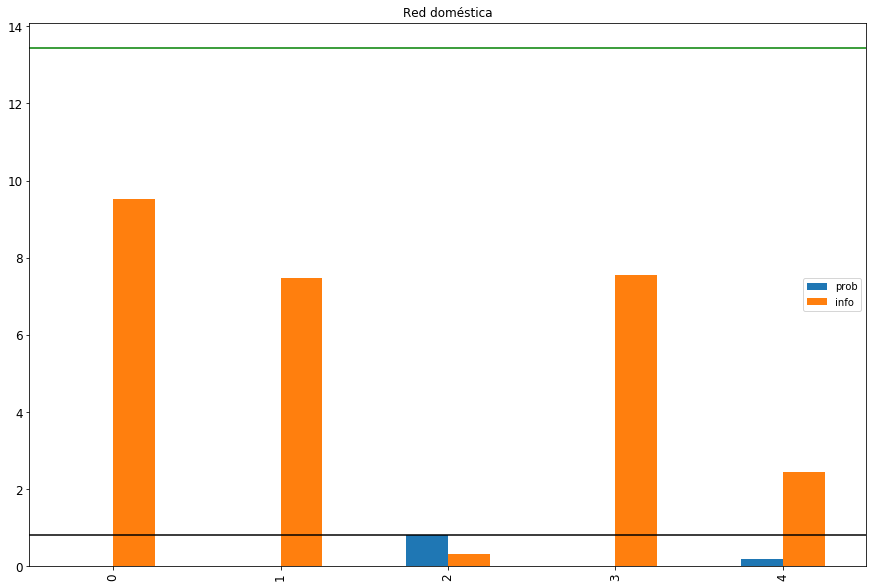

In [18]:
# Esto en realidad tendria que estar en ejes separados
graph_mh = data_mh[['prob','info']].plot(kind='bar', title ="Red doméstica", figsize=(15, 10), legend=True, fontsize=12)
graph_mh.axhline(entropy(data_mh), color='k', label='Entropía')
graph_mh.axhline(max_entropy(data_mh), color='g', label='Entropía máxima')